In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score,recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna
import shap
import joblib

In [2]:
df = pd.read_csv("/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/DATA/PROCESSED/Processed_churn_data.csv")

In [4]:
exclude = [col for col in df.columns if col.startswith('tenure_grp')] 
X = df.drop(columns = ['Churn']+exclude)
y= df['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 2,stratify=y)

#### DEFINING A FUNCTION THAT MEASURE EVERY EVALUATION METRIC

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score,recall_score, precision_score, f1_score

def evaluate(X_test,y_test,y_pred,model):
    print("accuracy:", accuracy_score(y_test,y_pred))
    print("Precision:", precision_score(y_test,y_pred))
    print("Recall:", recall_score(y_test,y_pred))
    print("F1:", f1_score(y_test,y_pred))
    print("roc AUC: ",roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    print("confusion_matrix\n",confusion_matrix(y_test,y_pred) )
    print("classification report:\n", classification_report(y_test,y_pred))


### WORKING ON RANDOM FOREST

In [ ]:
# BASE MODEL
rf_model = RandomForestClassifier(random_state=2,class_weight='balanced')
rf_model.fit(X_train,y_train)
rf_y_pred = rf_model.predict(X_test)

evaluate(X_test,y_test,rf_y_pred,rf_model)

accuracy: 0.7899219304471257
Precision: 0.6402877697841727
Recall: 0.47593582887700536
F1: 0.5460122699386503
roc AUC:  0.834274974812059
confusion_matrix
 [[935 100]
 [196 178]]
classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [ ]:
# FINDING THE BEST HYPERPARAMETERS
def rf_objective(trial):
    clf = RandomForestClassifier(
        n_estimators= trial.suggest_int('n_estimators',50,600),
        max_depth=trial.suggest_int('max_depth',3,50),
        min_samples_split = trial.suggest_int('min_samples_split',2,15),
        min_samples_leaf = trial.suggest_int('min_samples_leaf',2,15),
        max_features= trial.suggest_categorical("max_features",['log2','sqrt']),
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    f1 = cross_val_score(clf,X_train,y_train,cv=cv,scoring='f1').mean()
    return f1
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective,n_trials= 100)
print("best hyperparameter:",rf_study.best_params,"\n best value:", rf_study.best_value)

[I 2025-06-07 03:08:11,360] A new study created in memory with name: no-name-e94451ef-7e38-4aca-ac55-2aa62a4d7106
[I 2025-06-07 03:08:13,580] Trial 0 finished with value: 0.6287751662768254 and parameters: {'n_estimators': 416, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6287751662768254.
[I 2025-06-07 03:08:15,641] Trial 1 finished with value: 0.632498785795656 and parameters: {'n_estimators': 386, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.632498785795656.
[I 2025-06-07 03:08:18,285] Trial 2 finished with value: 0.6330128342298287 and parameters: {'n_estimators': 534, 'max_depth': 41, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 0.6330128342298287.
[I 2025-06-07 03:08:21,350] Trial 3 finished with value: 0.629775623521182 and parameters: {'n_estimators': 586, 'max_depth': 29,

best hyperparameter: {'n_estimators': 286, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'} 
 best value: 0.6364275379176655


In [15]:
rf_best = RandomForestClassifier(**rf_study.best_params,class_weight='balanced', random_state=42)
rf_best.fit(X_train, y_train)

rf_preds_final = rf_best.predict(X_test)
evaluate(X_test,y_test,rf_preds_final,rf_best)

accuracy: 0.7714691270404542
Precision: 0.5479704797047971
Recall: 0.7941176470588235
F1: 0.648471615720524
roc AUC:  0.8614069079542225
confusion_matrix
 [[790 245]
 [ 77 297]]
classification report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83      1035
           1       0.55      0.79      0.65       374

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.81      0.77      0.78      1409



In [20]:
joblib.dump(rf_best,"/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/MODEL/RF_chur.pkl")

['/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/MODEL/RF_chur.pkl']

In [13]:
scale = len(y_train[y_train==0])/len(y_train[y_train==1])

### WORKING ON XGBOOST

In [ ]:
# BASE MODEL
xgboost_model = XGBClassifier(random_state = 2, use_label_encoder = False, eval_metric= 'logloss', scale_pos_weight = scale)
xgboost_model.fit(X_train,y_train)
xgboost_y_pred = xgboost_model.predict(X_test)

evaluate(X_test,y_test,xgboost_y_pred,xgboost_model)

/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy: 0.7686302342086586
Precision: 0.5512820512820513
Recall: 0.6898395721925134
F1: 0.6128266033254157
roc AUC:  0.8297643958769279
confusion_matrix
 [[825 210]
 [116 258]]
classification report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.55      0.69      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



In [16]:
# HYPERPARAMETER TUNING
def xgb_objective(trial):
    clf = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators',100,600),
        max_depth = trial.suggest_int('max_depth',3,30),
        learning_rate = trial.suggest_float('learning_rate',0.01,0.3),
        subsample = trial.suggest_float('subsample',0.5,1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.0),
        scale_pos_weight = scale,
        eval_metric = 'logloss',
        random_state = 42,
        n_jobs = -1
    )
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state= 42)
    f1 = cross_val_score(clf,X_train,y_train,cv =cv ,scoring= 'f1').mean()
    return f1

xgboost_study = optuna.create_study(direction = "maximize")
xgboost_study.optimize(xgb_objective,n_trials= 200)

print("best hyperparameter: ",xgboost_study.best_params, "\n best value: ",xgboost_study.best_value)

[I 2025-06-07 03:10:55,799] A new study created in memory with name: no-name-f96255e8-dd91-4fad-82ed-b68b459d947c
[I 2025-06-07 03:11:07,432] Trial 0 finished with value: 0.5743954273454527 and parameters: {'n_estimators': 587, 'max_depth': 21, 'learning_rate': 0.046529222419177035, 'subsample': 0.9654561485158492, 'colsample_bytree': 0.9410297749524161}. Best is trial 0 with value: 0.5743954273454527.
[I 2025-06-07 03:11:15,658] Trial 1 finished with value: 0.5807580758832085 and parameters: {'n_estimators': 460, 'max_depth': 17, 'learning_rate': 0.028868264092483595, 'subsample': 0.521537741559962, 'colsample_bytree': 0.7049864529875761}. Best is trial 1 with value: 0.5807580758832085.
[I 2025-06-07 03:11:21,524] Trial 2 finished with value: 0.5612330058193864 and parameters: {'n_estimators': 429, 'max_depth': 17, 'learning_rate': 0.2981756636449289, 'subsample': 0.9397357863191353, 'colsample_bytree': 0.9100055284440282}. Best is trial 1 with value: 0.5807580758832085.
[I 2025-06-07

best hyperparameter:  {'n_estimators': 323, 'max_depth': 4, 'learning_rate': 0.010115987921874707, 'subsample': 0.5173288831301478, 'colsample_bytree': 0.9113113002198702} 
 best value:  0.6357996768214365


In [17]:
xgb_best = XGBClassifier(**xgboost_study.best_params,scale_pos_weight = scale, eval_metric = 'logloss',random_state = 42, n_jobs = -1)
xgb_best.fit(X_train,y_train)

xgb_pred_final = xgb_best.predict(X_test)
evaluate(X_test,y_test,xgb_pred_final,xgb_best)

accuracy: 0.7643718949609652
Precision: 0.5364583333333334
Recall: 0.8262032085561497
F1: 0.6505263157894737
roc AUC:  0.8627683484460978
confusion_matrix
 [[768 267]
 [ 65 309]]
classification report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1035
           1       0.54      0.83      0.65       374

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.76      0.78      1409



In [21]:
joblib.dump(xgb_best,"/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/MODEL/XGB_chur.pkl")

['/Users/mr.engineer/Desktop/Code/DSPROJECT/CUSTOMER_CHURN/MODEL/XGB_chur.pkl']

### FINDING FEATURE IMPORTANCE AND HOW EACH FEATURE CONTRIBUTE TO THE OVER ALL PREDICTION USING SHAP

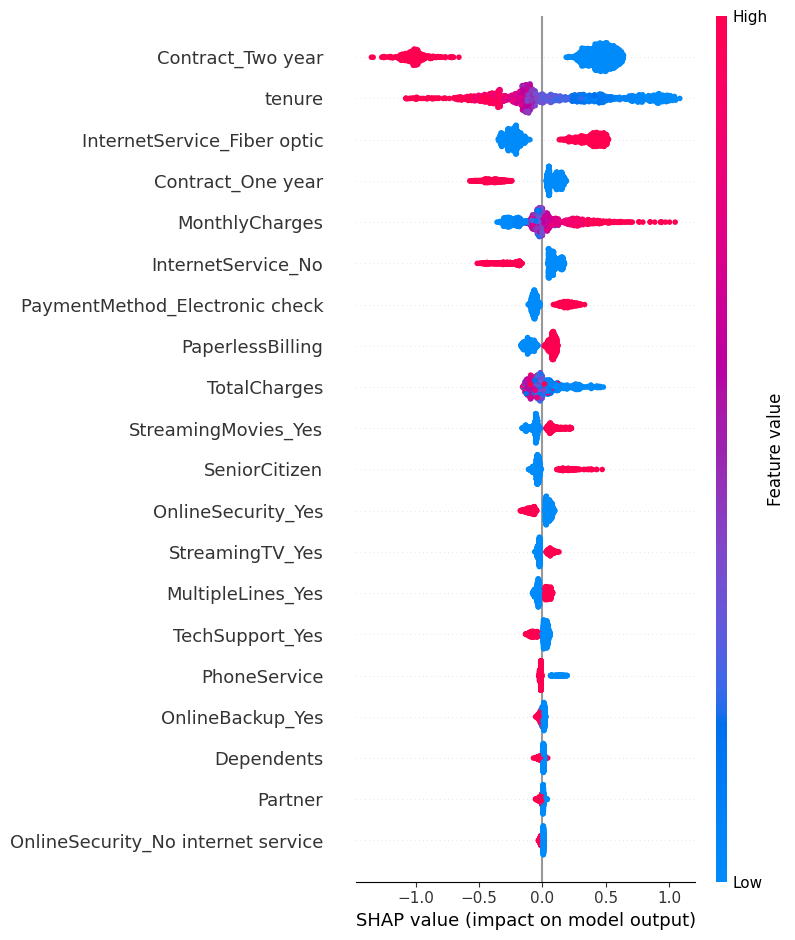

In [19]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
explainer = shap.Explainer(xgb_best, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)